<a href="https://colab.research.google.com/github/obarnstedt/LINdoscope2023/blob/main/notebooks/CEBRA_LINdoscope2023_1Pdemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 👋  Welcome to the CEBRA demo!


Adapted from https://github.com/stes/Nx-435_EPFL (Anastasiia Filippova & Mackenzie Mathis, viz by Oliver Barnstedt)

In [24]:
import cebra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import cebra.integrations.matplotlib as cebra_plot

from cebra import CEBRA

### Data loading

We have awesome integration of DeepLabCut, look [here](https://cebra.ai/docs/api/pytorch/data.html#cebra.load_deeplabcut) for more usage information on how to use deeplabcut output file directly with `cebra.load_deeplabcut`. Let's use it!

# 🦓 CEBRA training

- we recommend to start with CEBRA single session on each trial

- you can find our suggested workflow here: https://cebra.ai/docs/usage.html

## Single-session training w/CEBRA-Behavior

In [14]:
embeddings = dict()

for i, session in enumerate(sessions):

    cebra_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=5000,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)
    cebra_model.fit(session['neural'], session['tail_position'])
    embeddings[i] = cebra_model.transform(session['neural'])

pos:  0.2198 neg:  5.4216 total:  5.6414 temperature:  1.0000: 100%|██████████| 5000/5000 [01:09<00:00, 71.68it/s]
pos:  0.2897 neg:  5.4393 total:  5.7290 temperature:  1.0000: 100%|██████████| 5000/5000 [01:04<00:00, 78.12it/s]
pos:  0.3409 neg:  5.4458 total:  5.7866 temperature:  1.0000: 100%|██████████| 5000/5000 [01:20<00:00, 62.06it/s]


## Analyze the embedding, part 1:
- plot embedding #1

In [41]:
# # static plotting
# %matplotlib inline
# fig = plt.figure(figsize=(10, 4))

# ax1 = plt.subplot(131, projection='3d')
# ax2 = plt.subplot(132, projection='3d')
# ax3 = plt.subplot(133, projection='3d')
# axes = [ax1, ax2, ax3]

# for i, ax in enumerate(axes):
#     cebra_plot.plot_embedding(embeddings[i],
#                               cmap='magma',
#                               ax = ax,
#                               alpha=0.4,
#                               markersize=0.5,
#                               title = f'{i} session',
#                               embedding_labels=sessions[i]['tail_position'])

# interactive plots
fig = make_subplots(rows=1, cols=3,
                    specs=[[{'is_3d': True}, {'is_3d': True}, {'is_3d': True}]],
                    print_grid=False,
                    subplot_titles=([f'Session {i+1}' for i in range(3)])
)
fig.update_layout(template="plotly_white")

for i in range(3):
  fig.add_trace(
      go.Scatter3d(
          x=embeddings[i][:,0],
          y=embeddings[i][:,1],
          z=embeddings[i][:,2],
          mode='markers',
          marker=dict(
              size=3,
              color=sessions[i]['tail_position'].astype(float),   # set color to an array/list of desired values
              colorscale='magma',   # choose a colorscale
              line=dict(width=0)
          ),
      ), col=i+1, row=1)
fig.show()

Looks cool, right? 🎉 Lets boost our model by combining the data for training CEBRA in multisession regime:)

## CEBRA-Multisession

In [16]:
#this is just the list of neural data = [neural_data_1, ...]
datas = [session['neural'] for session in sessions]

#this is just the list of labels = [labels_1, ...]
labels = [session['tail_position'] for session in sessions]

In [17]:
multi_embeddings = dict()

# Multisession training
multi_cebra_model = CEBRA(model_architecture='offset10-model',
                    batch_size=1024,
                    learning_rate=3e-4,
                    temperature=1,
                    output_dimension=3,
                    max_iterations=500,
                    distance='cosine',
                    conditional='time_delta',
                    device='cuda_if_available',
                    verbose=True,
                    time_offsets=10)

multi_cebra_model.fit(datas, labels)



pos:  0.3646 neg:  7.2389 total:  7.6036 temperature:  1.0000: 100%|██████████| 500/500 [21:23<00:00,  2.57s/it]


CEBRA(batch_size=1024, conditional='time_delta', max_iterations=500,
      model_architecture='offset10-model', output_dimension=3, temperature=1,
      time_offsets=10, verbose=True)

In [18]:
for i, data in enumerate(datas):
    multi_embeddings[i] = multi_cebra_model.transform(data, session_id=i)

In [40]:
# # static plots:
# %matplotlib inline
# fig = plt.figure(figsize=(10, 4))

# ax1 = plt.subplot(131, projection='3d')
# ax2 = plt.subplot(132, projection='3d')
# ax3 = plt.subplot(133, projection='3d')
# axes = [ax1, ax2, ax3]

# for i, ax in enumerate(axes):
#     cebra_plot.plot_embedding(multi_embeddings[i],
#                               cmap='magma',
#                               ax = ax,
#                               alpha=0.4,
#                               markersize=0.5,
#                               title = f'{i} session',
#                               embedding_labels=sessions[i]['tail_position'])

# interactive plots
fig = make_subplots(rows=1, cols=3,
                    specs=[[{'is_3d': True}, {'is_3d': True}, {'is_3d': True}]],
                    print_grid=False,
                    subplot_titles=([f'Session {i+1}' for i in range(3)])
)
fig.update_layout(template="plotly_white")

for i in range(3):
  fig.add_trace(
      go.Scatter3d(
          x=multi_embeddings[i][:,0],
          y=multi_embeddings[i][:,1],
          z=multi_embeddings[i][:,2],
          mode='markers',
          marker=dict(
              size=3,
              color=sessions[i]['tail_position'].astype(float),   # set color to an array/list of desired values
              colorscale='magma',   # choose a colorscale
              line=dict(width=0)
          ),
      ), col=i+1, row=1)
fig.show()

### We also want to check consistency across sessions!

 - this is also useful to compare across animals (see Schneider, Lee, Mathis Nature 2023, Figure 1)
 - or compare across brain areas, tasks, etc .. anything you want to compare 🧠
 - in our case the comparison is across datasets (trials)

In [20]:
import cebra.integrations.sklearn.helpers as cebra_sklearn_helpers
import cebra.integrations.sklearn.metrics as cebra_sklearn_metrics

def consistency_datasets(embeddings,
                         labels,
                         nbins=64,
                         dataset_ids=None):

    if dataset_ids is None:
        dataset_ids = np.arange(len(embeddings))
    datasets = np.array(sorted(set(dataset_ids)))

    aligned_embeddings = cebra_sklearn_helpers.align_embeddings(
        embeddings, labels, n_bins=nbins)
    scores, pairs = cebra_sklearn_metrics._consistency_scores(aligned_embeddings,
                                        datasets=dataset_ids)
    between_dataset = [p[0] != p[1] for p in pairs]

    pairs = np.array(pairs)[between_dataset]
    scores = cebra_sklearn_metrics._average_scores(np.array(scores)[between_dataset], pairs)

    return (scores, pairs, datasets)


In [21]:
multi_embeddings_union = list(multi_embeddings.values())
tail_position_union = [session['tail_position']
                       for session in sessions]

In [22]:
scores, pairs, runs = consistency_datasets(embeddings=multi_embeddings_union,
                                            labels=tail_position_union)

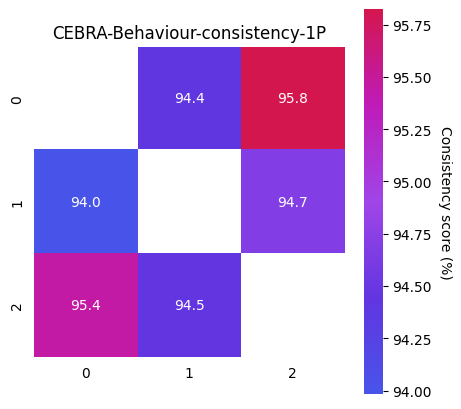

In [23]:
%matplotlib inline
ax = cebra_plot.plot_consistency(scores,
                                 pairs=pairs,
                                 datasets=runs,
                                 title="CEBRA-Behaviour-consistency-1P", cmap='cebra')

Great job! You are now master of CEBRA and DeepLabCut:)